In [11]:
import os
import keras
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [4]:
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

train_generator = ImageDataGenerator(validation_split=0.15) # VGG16 preprocessing

test_generator = ImageDataGenerator() # VGG16 preprocessing

In [5]:
download_dir = Path("./oct2017/OCT2017 /")

In [6]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

class_subset = ['CNV', 'DME', 'DRUSEN', 'NORMAL'] # Using only the first 10 classes

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset = 'validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 83484 images belonging to 4 classes.
Found 12521 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [18]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    # top_model = Dense(4096, activation='relu')(top_model)
    # top_model = Dense(1072, activation='relu')(top_model)
    # top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
input_shape = (150, 150, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [24]:
print(f'number of val steps {n_val_steps}')

number of val steps 195


In [13]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [21]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

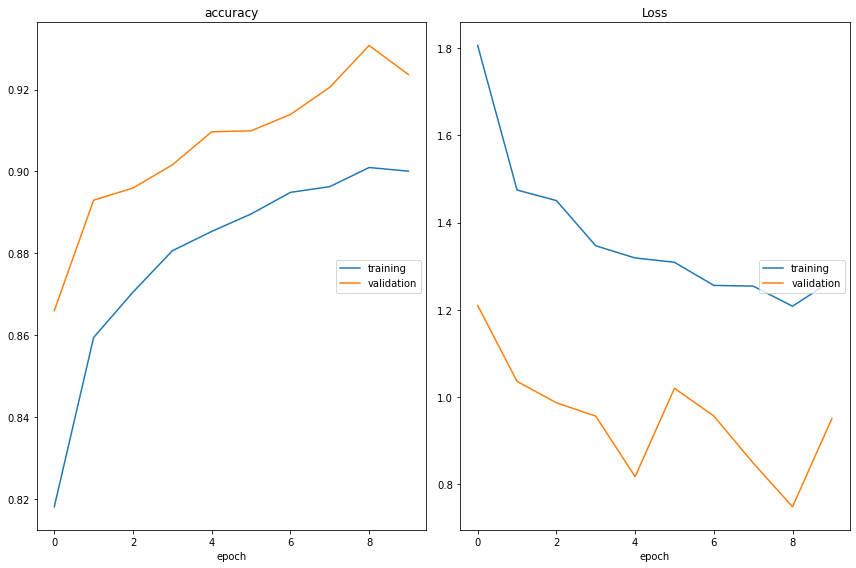

accuracy
	training         	 (min:    0.818, max:    0.901, cur:    0.900)
	validation       	 (min:    0.866, max:    0.931, cur:    0.924)
Loss
	training         	 (min:    1.209, max:    1.806, cur:    1.267)
	validation       	 (min:    0.749, max:    1.210, cur:    0.951)
1305/1305 [==============================] - 302s 231ms/step - loss: 1.2673 - accuracy: 0.9001 - val_loss: 0.9510 - val_accuracy: 0.9236
CPU times: user 55min 35s, sys: 2min 3s, total: 57min 39s
Wall time: 57min 28s


In [27]:
%%time 

# vgg_history = vgg_model.fit(traingen,
#                             batch_size=BATCH_SIZE,
#                             epochs=n_epochs,
#                             validation_data=validgen,
#                             steps_per_epoch=n_steps,
#                             validation_steps=n_val_steps,
#                             callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
#                             verbose=1)

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [28]:
vgg_model.evaluate(testgen)

968/968 [==============================] - 8s 7ms/step - loss: 0.6426 - accuracy: 0.9401


[0.6425835490226746, 0.9400826692581177]

In [29]:
vgg_model.save("Models/vgg16_initial")

2022-06-21 23:20:19.114987: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/vgg16_initial/assets


In [12]:
vgg_model = keras.models.load_model("Models/vgg16_initial")

2022-06-22 14:29:42.513434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:29:42.724599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:29:42.725302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:29:42.726688: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Fine tuning of VGG16 Model

In [17]:
traingen.reset()
testgen.reset()
validgen.reset()

In [23]:
input_shape = (150, 150, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_1, fine_tune=2)

In [24]:
vgg_model_ft.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

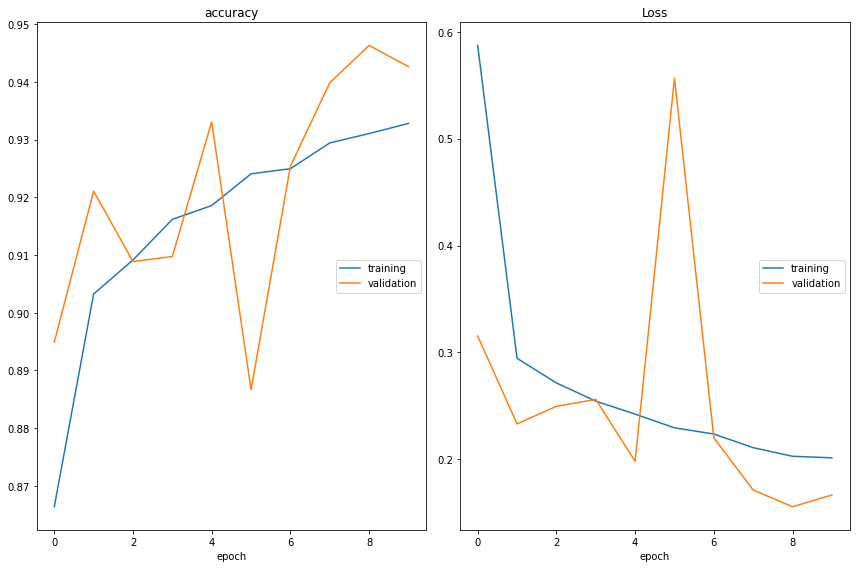

accuracy
	training         	 (min:    0.866, max:    0.933, cur:    0.933)
	validation       	 (min:    0.887, max:    0.946, cur:    0.943)
Loss
	training         	 (min:    0.201, max:    0.587, cur:    0.201)
	validation       	 (min:    0.156, max:    0.557, cur:    0.167)
1305/1305 [==============================] - 300s 230ms/step - loss: 0.2014 - accuracy: 0.9328 - val_loss: 0.1666 - val_accuracy: 0.9427
CPU times: user 56min 18s, sys: 2min 36s, total: 58min 54s
Wall time: 1h 12min 8s


In [25]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [26]:
vgg_model_ft.evaluate(testgen)

968/968 [==============================] - 9s 8ms/step - loss: 0.1006 - accuracy: 0.9618


[0.100626140832901, 0.961776852607727]

In [27]:
vgg_model_ft.save("Models/vgg16_initial_ft")

2022-06-22 16:19:49.297635: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/vgg16_initial_ft/assets


In [28]:
import gc

gc.collect()

19939